In [1]:
import imp
import time
import argparse
import numpy as np
import torch
torch.set_printoptions(threshold=10000)
from torch_geometric.datasets import Planetoid,Reddit2,Flickr
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# from torch_geometric.loader import DataLoader
from help_funcs import prune_unrelated_edge,prune_unrelated_edge_isolated, clu_prune_unrelated_edge
import scipy.sparse as sp
from torch_geometric.utils import subgraph
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--debug', action='store_true',
        default=True, help='debug mode')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=12, help='Random seed.')
parser.add_argument('--model', type=str, default='GCN', help='model',
                    choices=['GCN','GAT','GraphSage','GIN'])
parser.add_argument('--dataset', type=str, default='Pubmed', 
                    help='Dataset',
                    choices=['Cora','Pubmed','Flickr','ogbn-arxiv','Citeseer','Reddit2'])
parser.add_argument('--train_lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=128,
                    help='Number of hidden units.')
parser.add_argument('--thrd', type=float, default=0.5)
parser.add_argument('--target_class', type=int, default=2)
parser.add_argument('--k', type=int, default=100)
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--epochs', type=int,  default=1000, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--rec_epochs', type=int,  default=30, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--trojan_epochs', type=int,  default=400, help='Number of epochs to train trigger generator.')
parser.add_argument('--inner', type=int,  default=1, help='Number of inner')
# backdoor setting
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--trigger_size', type=int, default=3,
                    help='tirgger_size')
parser.add_argument('--use_vs_number', action='store_true', default=True,
                    help="if use detailed number to decide Vs")
parser.add_argument('--vs_ratio', type=float, default=0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--range', type=float, default=1.0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--vs_number', type=int, default=160,
                    help="number of poisoning nodes relative to the full graph")
# defense setting
parser.add_argument('--defense_mode', type=str, default="none",
                    choices=['prune', 'isolate', 'none','reconstruct'],
                    help="Mode of defense")
parser.add_argument('--prune_thr', type=float, default=0.8,
                    help="Threshold of prunning edges")
parser.add_argument('--target_loss_weight', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_target', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_ood', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_targetclass', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--outter_size', type=int, default=4096,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--homo_loss_weight', type=float, default=100,
                    help="Weight of optimize similarity loss")
parser.add_argument('--homo_boost_thrd', type=float, default=0.8,
                    help="Threshold of increase similarity")
# attack setting
parser.add_argument('--dis_weight', type=float, default=1,
                    help="Weight of cluster distance")
parser.add_argument('--selection_method', type=str, default='none',
                    choices=['loss','conf','cluster','none','cluster_degree'],
                    help='Method to select idx_attach for training trojan model (none means randomly select)')
parser.add_argument('--test_model', type=str, default='GCN',
                    choices=['GCN','GAT','GraphSage','GIN'],
                    help='Model used to attack')
parser.add_argument('--evaluate_mode', type=str, default='1by1',
                    choices=['overall','1by1'],
                    help='Model used to attack')
# GPU setting
parser.add_argument('--device_id', type=int, default=2,
                    help="Threshold of prunning edges")
# args = parser.parse_args()
args = parser.parse_known_args()[0]
args.cuda =  not args.no_cuda and torch.cuda.is_available()
device = torch.device(('cuda:{}' if torch.cuda.is_available() else 'cpu').format(args.device_id))

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
print(args)

/tmp/ipykernel_1769512/1338765424.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(cuda=True, dataset='Pubmed', debug=True, defense_mode='none', device_id=2, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=128, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=12, selection_method='none', target_class=2, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=40, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [2]:
from torch_geometric.utils import to_undirected
import torch_geometric.transforms as T
transform = T.Compose([T.NormalizeFeatures()])

if(args.dataset == 'Cora' or args.dataset == 'Citeseer' or args.dataset == 'Pubmed'):
    dataset = Planetoid(root='./data/', \
                        name=args.dataset,\
                        transform=transform)
elif(args.dataset == 'Flickr'):
    dataset = Flickr(root='./data/Flickr/', \
                    transform=transform)
elif(args.dataset == 'Reddit2'):
    dataset = Reddit2(root='./data/Reddit2/', \
                    transform=transform)
elif(args.dataset == 'ogbn-arxiv'):
    from ogb.nodeproppred import PygNodePropPredDataset
    # Download and process data at './dataset/ogbg_molhiv/'
    dataset = PygNodePropPredDataset(name = 'ogbn-arxiv', root='./data/')
    split_idx = dataset.get_idx_split() 

data = dataset[0].to(device)

if(args.dataset == 'ogbn-arxiv'):
    nNode = data.x.shape[0]
    setattr(data,'train_mask',torch.zeros(nNode, dtype=torch.bool).to(device))
    # dataset[0].train_mask = torch.zeros(nEdge, dtype=torch.bool).to(device)
    data.val_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.test_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.y = data.y.squeeze(1)
    
if(args.dataset == 'Reddit2'):
    num_nodes_to_sample = 20000  # Adjust this based on your needs

    # Randomly select a subset of nodes
    sampled_nodes = torch.randint(data.num_nodes, (num_nodes_to_sample,), device=device)

    # Perform subgraph sampling
    edge,_ = subgraph(sampled_nodes, data.edge_index)
    data.edge_index = edge

In [3]:
from utils import get_split
data, idx_train, idx_val, idx_clean_test, idx_atk = get_split(args,data,device)

from torch_geometric.utils import to_undirected
from utils import subgraph
data.edge_index = to_undirected(data.edge_index)
train_edge_index,_, edge_mask = subgraph(torch.bitwise_not(data.test_mask),data.edge_index,relabel_nodes=False)
mask_edge_index = data.edge_index[:,torch.bitwise_not(edge_mask)]

In [4]:
from sklearn_extra import cluster
from models.backdoor import Backdoor
from models.construct import model_construct
import heuristic_selection as hs
from torch.distributions.bernoulli import Bernoulli

# select poisoned target node #

# filter out the unlabeled nodes except from training nodes and testing nodes, nonzero() is to get index, flatten is to get 1-d tensor
unlabeled_idx = (torch.bitwise_not(data.test_mask)&torch.bitwise_not(data.train_mask)).nonzero().flatten()
if(args.use_vs_number):
    size = args.vs_number
else:
    size = int((len(data.test_mask)-data.test_mask.sum())*args.vs_ratio)
# print("#Attach Nodes:{}".format(size))
assert size>0, 'The number of selected trigger nodes must be larger than 0!'
# here is randomly select poison nodes from unlabeled nodes
if(args.selection_method == 'none'):
    idx_attach = hs.obtain_attach_nodes(args,unlabeled_idx,size)
elif(args.selection_method == 'cluster'):
    idx_attach = hs.cluster_distance_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
elif(args.selection_method == 'cluster_degree'):
    if(args.dataset == 'Pubmed'):
        idx_attach = hs.cluster_degree_selection_seperate_fixed(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    else:
        idx_attach = hs.cluster_degree_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
# print("idx_attach: {}".format(idx_attach))
unlabeled_idx = torch.tensor(list(set(unlabeled_idx.cpu().numpy()) - set(idx_attach.cpu().numpy()))).to(device)
print('number of benign training nodes', len(idx_train))
print('number of poisoned target nodes', len(idx_attach))

# Cora
# idx_attach = torch.tensor([1672, 2399, 1785, 2020, 2013, 1652,  208, 1220, 2128,  446])
# Flicker
idx_attach = torch.tensor([12920,  5748,   335,  7120, 18789,  5694,  5027,  9887,  4708,  5415,
        12888,  2522, 19223,  8307, 12262,  4615,  2678,  5695,  8932,  7129,
         4126, 19204, 12011, 13717, 18839, 12244,  6280,  7239, 18495,  7435,
         8668,  8733,   616,  6642, 16044, 16149, 17486, 19442, 18364,  1678,
        10506, 15396, 10231,  6171, 11414, 14912,   492,  8854, 16195,  4930,
         5386,   287, 14186,  5531, 16608,  8935, 13825,  2897, 16203, 14594,
        19067,  4256, 12628,  1259,  7193,  7196, 16269,  1727,  1967,  4330,
        18725, 17459, 14340, 18922, 17790,  5394,  4935, 17536, 13882, 10423,
         2896,  9880, 19443, 19278,  2470, 11318, 11186, 16732,  9204, 16023,
          849,  8566,  2659, 14506,  1515,  4871, 10751, 13827, 11250, 14074,
         8382,  6565, 11569, 19582,  3733, 15598, 15004,  8322, 10158,  8671,
        19246, 10811,  7763, 14690,   430, 18823,   564, 17209, 13057, 14357,
         3905,  3765, 17191, 19580, 18803,  9147,  6114, 18261, 12999, 14891,
         5678, 11681, 13933, 14946,  4080, 12062,  4501,   397,  4290,  2655,
         8217, 12543, 13982,  1128, 10369,  1732,  1497,  6689,  2147,  9542,
         1975,   706, 11153, 19471,  3148, 10812,  2347,  1146, 15423,  3562])

idx_attach = idx_attach.to(device)

number of benign training nodes 3943
number of poisoned target nodes 40


In [5]:
## trigger generator ##
model = Backdoor(args,device)
model.fit(data.x, train_edge_index, None, data.y, idx_train,idx_attach, unlabeled_idx, True)

0

In [6]:
test_model = 'GCN'
total_overall_asr = 0
total_overall_ca = 0
args.test_model = test_model
rs = np.random.RandomState(args.seed)
seeds = rs.randint(1000,size=1)
overall_asr = 0
overall_ca = 0

In [7]:
# load poisoned graph #
# poison_x = torch.load('poison_x.pt')
# poison_edge_index = torch.load('poison_edge_index.pt')
# poison_edge_weights = torch.load('poison_edge_weights.pt')
# poison_labels = torch.load('poison_labels.pt')
poison_x = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_x_pubmed.pt')
poison_edge_index = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_edge_index_pubmed.pt')
poison_edge_weights = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_edge_weights_pubmed.pt')
poison_labels = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_labels_pubmed.pt')
# poison_x = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_x.pt')
# poison_edge_index = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_edge_index.pt')
# poison_edge_weights = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_edge_weights.pt')
# poison_labels = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_labels.pt')

In [8]:
print(args)

mask = data.y[idx_attach] != args.target_class
mask = mask.to(device)

## only attack those has groud truth labels != target_class ##
idx_attach = idx_attach[(data.y[idx_attach] != args.target_class).nonzero().flatten()]

bkd_tn_nodes = torch.cat([idx_train,idx_attach]).to(device)
# test_model = model_construct(args,args.test_model,data,device).to(device) 
known_nodes = torch.cat([idx_train,idx_attach]).to(device)
predictions = []
# edge weight for clean edge_index, may use later #
edge_weight = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)


Namespace(cuda=True, dataset='Pubmed', debug=True, defense_mode='none', device_id=2, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=128, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=12, selection_method='none', target_class=2, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=40, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [9]:
mask.sum()

tensor(24, device='cuda:2')

In [10]:
print(data.y[idx_attach])
# idx_attach is selected target node #
print(poison_labels[idx_attach])

tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1],
       device='cuda:2')
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:2')


In [11]:
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False)
test_model.eval()
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)
output_clean, x = test_model(poison_x,poison_edge_index,poison_edge_weights)
ori_predict = torch.exp(output_clean[known_nodes])
print("accuracy on poisoned target nodes: {:.4f}".format(clean_acc))

accuracy on poisoned target nodes: 0.8750


In [12]:
output_clean[idx_attach].argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2],
       device='cuda:2')

In [13]:
# test backdoored model for comparison #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output, x = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.9204
Flip ASR: 0.8765/1198 nodes
CA: 0.8447


In [14]:
# edge drop #
def sample_noise_all(edge_index, edge_weight,device):
    noisy_edge_index = edge_index.clone().detach()
    if(edge_weight == None):
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    else:
        noisy_edge_weight = edge_weight.clone().detach()
    # # rand_noise_data = copy.deepcopy(data)
    # rand_noise_data.edge_weight = torch.ones([rand_noise_data.edge_index.shape[1],]).to(device)
    m = Bernoulli(torch.tensor([0.5]).to(device))
    mask = m.sample(noisy_edge_weight.shape).squeeze(-1).int()
    # print('mask',mask)
    rand_inputs = torch.randint_like(noisy_edge_weight, low=0, high=2).squeeze().int().to(device)
    # print(rand_noise_data.edge_weight.shape,mask.shape)
    noisy_edge_weight = noisy_edge_weight * mask #+ rand_inputs * (1-mask)
        
    if(noisy_edge_weight!=None):
        noisy_edge_index = noisy_edge_index[:,noisy_edge_weight.nonzero().flatten().long()]
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    return noisy_edge_index, noisy_edge_weight

In [15]:
# test robustness #
for i in range(20):
            test_model.eval()
            noisy_poison_edge_index, noisy_poison_edge_weights = sample_noise_all(poison_edge_index, poison_edge_weights, device)
            output, x = test_model(poison_x,noisy_poison_edge_index,noisy_poison_edge_weights)
            train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
            train_clean_rate = (output.argmax(dim=1)[idx_train]==data.y[idx_train]).float().mean()
            predictions.append(torch.exp(output[known_nodes]))

In [16]:
# torch.argmax(predictions[8][23868])

In [17]:
epsilon = 1e-8
deviations = []
for sub_pred in predictions:
    sub_pred += epsilon
    deviation = F.kl_div(sub_pred.log(), ori_predict, reduce=False)
    deviations.append(deviation)

summed_deviations = torch.zeros_like(deviations[0]).to(deviations[0].device)
for deviation in deviations:
    ##### summed deviations for each node #####
    summed_deviations += deviation


##### get the index for nodes with less robustness #####
    
##### args.vs_number is unknown #####
index_of_less_robust = torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[1][:mask.sum()]
print('index_of_less_robust',index_of_less_robust)

##### count how many poisoned target nodes are selected in less robustness nodes #####
count = 0
dd = []
for idx in index_of_less_robust:
    if idx >= len(known_nodes)-args.vs_number:
        count += 1
        dd.append(idx)
print('count',count)

index_of_less_robust tensor([3954, 3966, 3958, 3945, 3943, 3955, 3961,  307, 3950, 2348, 3944, 3964,
        3953, 3946, 3952, 3132, 3962,  511, 3959,  473, 3949, 3960, 2067, 3858],
       device='cuda:2')
count 17


/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [18]:
torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[0][:mask.sum()]

tensor([20.1211, 17.3176, 13.4710, 13.2979, 11.1514, 10.5073,  9.8286,  9.6228,
         9.5437,  9.5262,  9.1089,  9.0160,  8.8755,  8.8265,  8.3635,  8.2422,
         7.8644,  7.8208,  7.7789,  7.7620,  7.6605,  6.6720,  6.5867,  6.5070],
       device='cuda:2', grad_fn=<SliceBackward0>)

In [19]:
print(len(ori_predict))
mask.sum()

3967


tensor(24, device='cuda:2')

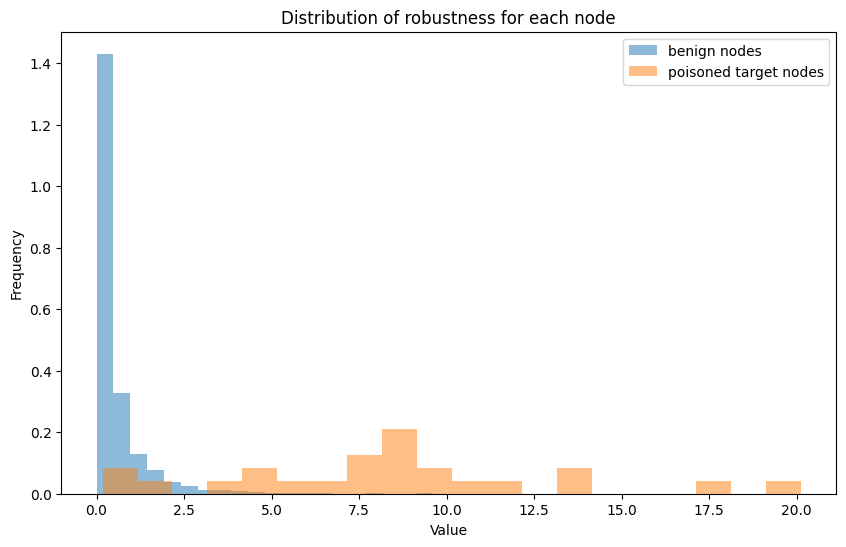

In [20]:


# visualize robustness distribution #
a=torch.mean(summed_deviations,dim=-1)
a_excluding_last_40 = a[:-args.vs_number].detach().cpu()
a_last=a[-mask.sum():].detach().cpu()


a_last_40 = a[-args.vs_number:].detach().cpu()




indices_to_remove = [i for i, node in enumerate(known_nodes[-args.vs_number:]) if data.y[node] == args.target_class]

indices_to_remove = []

a_last_list = list(a_last)

indices_to_check = range(len(known_nodes[-args.vs_number:]))

# indices_to_remove = []

# ##### find those nodes that are already have target class or poisoned failed #####
# for i in indices_to_check:
#     condition1 = data.y[known_nodes[-args.vs_number:][i]] == args.target_class
#     condition2 = output.argmax(dim=1)[idx_attach[i]] != args.target_class
    
#     if condition1 or condition2:
#         indices_to_remove.append(i)

# for index in sorted(indices_to_remove, reverse=True):
#     del a_last_list[index]


a_last_40 = a_last_list
plt.figure(figsize=(10, 6))
# plt.figure(figsize=(40, 24))
##### benign nodes #####
plt.hist(a_excluding_last_40, bins=20, alpha=0.5, label='benign nodes', density=True)
##### poisoned success nodes #####
plt.hist(a_last_40, bins=20, alpha=0.5, label='poisoned target nodes',density=True)
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of robustness for each node')
plt.savefig('a.jpg')
plt.show()

In [21]:
output_clean[idx_attach].argmax(dim=1)
output_clean = torch.exp(output_clean)

In [22]:
import torch
from torch_geometric.utils import k_hop_subgraph
epsilon = 1e-8

print(output_clean[idx_attach].argmax(dim=1))


from torch_geometric.utils import k_hop_subgraph
result_clean=[]
for node_id in idx_train[:300]:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output, x = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        result_clean.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_clean)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2],
       device='cuda:2')
[0.0003840153513010591, 2.77856997854542e-05, 0.0001921132206916809, 0.006083197891712189, 0.0006437736446969211, 0.0016895979642868042, 0.002538193017244339, 0.0015582777559757233, 0.0021918579004704952, 0.0016334082465618849, 0.004585096146911383, 0.01081586442887783, 0.006779960356652737, 0.0020329728722572327, 0.0021397448144853115, 0.00307646906003356, 0.0005128085613250732, 0.0030900153797119856, 0.0025042674969881773, 0.0036825290881097317, 0.004130852874368429, 0.0043451255187392235, 0.002333572832867503, 0.0031433547846972942, 0.003330643754452467, 0.043144188821315765, 0.0133495032787323, 1.2369206160656177e-05, 0.008624851703643799, 0.01809440180659294, 0.00026568275643512607, 0.0001507041451986879, 0.01099238358438015, 0.00392691045999527, 0.0015320803504437208, 0.0012995688011869788, 0.0035156558733433485, 0.01071795355528593, 0.003713419195264578, 0.00810655951499939, 

In [23]:
result_trigger = []
for node_id in idx_attach:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output, x = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
        if loop_edges[:,i][1]>len(data.x):
            # print(loop_edges[:,i][1])
            result_trigger.append(deviation.mean().item())
            
        # else:
        # print(deviation.mean().item())
            # result_clean.append(deviation.mean().item())

        # result_trigger.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_trigger)

[0.7743394374847412, 0.9410644769668579, 0.8466309905052185, 0.20735733211040497, 0.08626192808151245, 0.6287716627120972, 0.7203760147094727, 0.6604903340339661, 0.6130763292312622, 0.6034482717514038, 1.6757550239562988, 0.8261656761169434, 0.325477659702301, 0.014413321390748024, 1.0357259511947632, 0.18851207196712494, 0.3064497113227844, 0.5452321767807007, 0.1957579106092453, 0.0016557553317397833, 0.7034531831741333, 0.562968373298645, 1.5729012489318848]


In [24]:
print(len(result_trigger))
print(min(result_trigger))
print(max(result_trigger))
print(sorted(result_trigger,reverse=True))
print(max(result_clean))
print(sorted(result_clean,reverse=True))

23
0.0016557553317397833
1.6757550239562988
[1.6757550239562988, 1.5729012489318848, 1.0357259511947632, 0.9410644769668579, 0.8466309905052185, 0.8261656761169434, 0.7743394374847412, 0.7203760147094727, 0.7034531831741333, 0.6604903340339661, 0.6287716627120972, 0.6130763292312622, 0.6034482717514038, 0.562968373298645, 0.5452321767807007, 0.325477659702301, 0.3064497113227844, 0.20735733211040497, 0.1957579106092453, 0.18851207196712494, 0.08626192808151245, 0.014413321390748024, 0.0016557553317397833]
0.47750577330589294
[0.47750577330589294, 0.43351539969444275, 0.38672110438346863, 0.35369277000427246, 0.31924933195114136, 0.2548631727695465, 0.25451183319091797, 0.20993082225322723, 0.17008888721466064, 0.16527414321899414, 0.15866053104400635, 0.15754947066307068, 0.15444666147232056, 0.15132379531860352, 0.14289411902427673, 0.13670095801353455, 0.12740932404994965, 0.1219063550233841, 0.12018226087093353, 0.11756908893585205, 0.11364229768514633, 0.10660290718078613, 0.104400

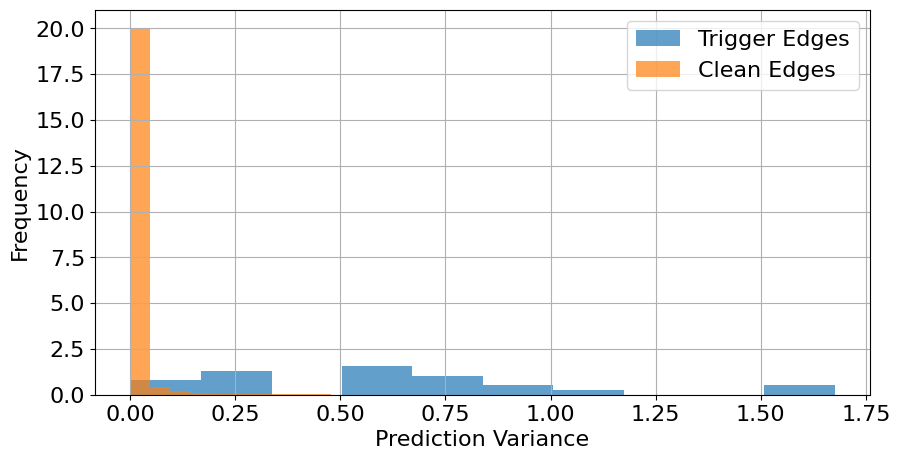

In [25]:
import matplotlib.pyplot as plt

# Ensure you have your data loaded in result_clean and result_trigger
# Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]
# result_trigger = [x for x in result_trigger if x < 0.8 and x>0.2]
# result_clean = [x for x in result_clean if x < 2 and x>0.2]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edge',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edge',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# # plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Prediction Variance')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)

# # Save the plot before displaying it
# plt.savefig('cora.pdf')

# # Display the plot
# plt.show()
plt.figure(figsize=(10, 5))

plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edges', density=True)
plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edges', density=True)

plt.xlabel('Prediction Variance',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

# Adjust x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.grid(True)

# Add a caption below the figure
# plt.figtext(0.5, -0.05, 'Comparison of prediction variance due to trigger edges drop and clean edges drop.', wrap=True, horizontalalignment='center', fontsize=14)

# Save the plot before displaying it
plt.savefig('cora.pdf')

# Display the plot
plt.show()

In [26]:
# result_clean=[]
# for node_id in idx_train[:10000]:
#     node_id = node_id.item()
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
#     loop_edges = edge_index[:, edge_index[0] == node_id]
#     non_loop_edges = edge_index[:, edge_index[0] != node_id]

#     selected_x = poison_x[subset]
    
#     for i in range(loop_edges.size(1)):
#         # Current loop edge to remove
#         current_loop_edge = loop_edges[:, i]

#         # Find indices of the current loop edge and its reverse
#         forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
#         reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

#         # Combine masks for forward and reverse edges
#         combined_mask = forward_edge_mask | reverse_edge_mask

#         # Remove both forward and reverse edges from the graph
#         modified_edge_index = edge_index[:, ~combined_mask]

#         edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

#         output, x = test_model(poison_x, modified_edge_index, edge_weights)
#         output = output[node_id]
#         output = torch.exp(output)
#         output += epsilon
#         deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
#         result_clean.append(deviation.mean().item())
#         print(deviation.mean().item())
# print(result_clean)


In [27]:
# result_trigger = []
# for node_id in idx_attach:
#     node_id = node_id.item()
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
#     loop_edges = edge_index[:, edge_index[0] == node_id]
#     non_loop_edges = edge_index[:, edge_index[0] != node_id]

#     selected_x = poison_x[subset]
    
#     for i in range(loop_edges.size(1)):
#         # Current loop edge to remove
#         current_loop_edge = loop_edges[:, i]

#         # Find indices of the current loop edge and its reverse
#         forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
#         reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

#         # Combine masks for forward and reverse edges
#         combined_mask = forward_edge_mask | reverse_edge_mask

#         # Remove both forward and reverse edges from the graph
#         modified_edge_index = edge_index[:, ~combined_mask]

#         edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

#         output, x = test_model(poison_x, modified_edge_index, edge_weights)
#         output = output[node_id]
#         output = torch.exp(output)
#         output += epsilon
#         deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
#         if loop_edges[:,i][1]>len(data.x):
#             result_trigger.append(deviation.mean().item())
#         else:
#             print(deviation.mean().item())
#             # result_clean.append(deviation.mean().item())

#         result_trigger.append(deviation.mean().item())
#         print(deviation.mean().item())
# print(result_trigger)


In [28]:
# import matplotlib.pyplot as plt

# # Ensure you have your data loaded in result_clean and result_trigger
# # Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()

In [29]:
poison_labels[idx_attach] = args.target_class

In [30]:
len(idx_attach)

24

In [31]:
## retrain a model on purified graph ##

# labels for target poisoned node before purified #
print(poison_labels[idx_attach])

# purifying #
# for idx in index_of_less_robust:
#     poison_labels[bkd_tn_nodes[idx]]=data.y[bkd_tn_nodes[idx]]
# # poison_labels[idx_attach] = data.y[idx_attach]

# # labels for target poisoned node after purified #
# print(poison_labels[idx_attach])

# retrain a model #s
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False, finetune=True, attach=index_of_less_robust)

## test model on purified graph (poisoned target node) ##
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)

print("accuracy on clean test nodes: {:.4f}".format(clean_acc))

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       device='cuda:2')
accuracy on clean test nodes: 0.0000


In [32]:
# add a trigger detector #
# assumption: backdoor attack's success is based on trigger pattern #
# 1. outlier, trigger different to each other #
# 2. in distribution, trigger similar to each other #
# # in case, model trained on clean graph learn attack pattern #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
# induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_attach,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output, x = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
# train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.2475
Flip ASR: 0.0292/1198 nodes
CA: 0.8417


In [33]:
output.argmax(dim=1)[idx_atk]

tensor([1, 0, 1, 2, 2, 0, 1, 1, 1, 0, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1,
        2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 1,
        2, 0, 1, 1, 0, 1, 1, 2, 1, 0, 0, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 2, 1,
        0, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 1,
        1, 2, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 1,
        2, 2, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 2, 0, 1, 0, 1, 0, 2, 1, 2, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 2,
        1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 2,
        1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 2, 0, 0,
        0, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 1, 2, 1,
        1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 0, 1, 0, 2, 2, 1, 2, 1, 1, 1, 0, 2, 2, 1,
        2, 0, 0, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1,
        1, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1,

In [34]:
probs=F.softmax(output[index_of_less_robust], dim=1)
probs

tensor([[4.1992e-02, 8.4388e-01, 1.1413e-01],
        [1.6817e-02, 7.8863e-02, 9.0432e-01],
        [4.0871e-02, 8.8127e-01, 7.7855e-02],
        [2.9108e-01, 6.7536e-01, 3.3568e-02],
        [6.2516e-01, 2.9115e-01, 8.3690e-02],
        [9.1219e-01, 2.5170e-02, 6.2643e-02],
        [5.2304e-03, 1.0460e-01, 8.9017e-01],
        [3.7861e-01, 6.2069e-01, 7.0607e-04],
        [3.3264e-02, 8.4224e-01, 1.2449e-01],
        [2.2674e-02, 7.8714e-01, 1.9018e-01],
        [2.7897e-02, 8.6807e-01, 1.0404e-01],
        [2.5140e-02, 8.4459e-01, 1.3027e-01],
        [5.3467e-01, 3.1623e-01, 1.4910e-01],
        [1.0083e-01, 6.5302e-02, 8.3387e-01],
        [1.9930e-02, 7.9555e-01, 1.8452e-01],
        [7.4998e-02, 7.8491e-01, 1.4009e-01],
        [2.7666e-02, 8.4611e-01, 1.2623e-01],
        [1.2703e-02, 7.0633e-01, 2.8096e-01],
        [1.3679e-02, 2.2021e-02, 9.6430e-01],
        [7.3490e-01, 1.3095e-01, 1.3415e-01],
        [2.4855e-02, 7.6343e-01, 2.1172e-01],
        [1.6283e-02, 7.0443e-01, 2

In [35]:
probs[range(len(poison_labels[index_of_less_robust])), poison_labels[index_of_less_robust]]

tensor([0.8439, 0.9043, 0.8813, 0.6754, 0.6252, 0.9122, 0.8902, 0.6207, 0.8422,
        0.7871, 0.8681, 0.8446, 0.3162, 0.8339, 0.7956, 0.7849, 0.8461, 0.7063,
        0.9643, 0.1341, 0.7634, 0.7044, 0.6781, 0.8275], device='cuda:2',
       grad_fn=<IndexBackward0>)

In [36]:
poison_labels[index_of_less_robust]

tensor([1, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1],
       device='cuda:2')